# NTDS assignment 3: spectral graph theory
[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL LTS2](http://lts2.epfl.ch)

The first two assignments were designed to warm you up. This third assignment is closer to what we expect you to do for the projects. It mainly misses the exploratory data analysis part (though there is some in sections 5.1 and 5.2). As such, our plan for this assignement encompasses data collection and exploitation, and goes as follows:
1. Data collection: use a web API to collect the musical genre of 2000 songs.
2. Feature extraction: compute features from audio tracks.
3. Graph construction: construct a nearest-neighbor graph from the features.
4. Eigendecomposition: factorization of the graph Laplacian (c.f. spectral graph theory).
5. Visualization & Clustering: using the graph and eigenvectors to visualize the dataset and to cluster the tracks.
6. Conclusion: a reflexion about what we did (though realisations are scattered all along).

The data we are using for this assignment is a subset of the [Free Music Archive dataset](https://github.com/mdeff/fma), a collection of 1TB of music with metadata released under a permissive license.

In [1]:
%matplotlib inline

import configparser
import os
import networkx as nx
import itertools as it

import requests
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition, model_selection
import librosa
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (17, 5)

If the above cell fails, it's most probably because you miss a package. Install them with e.g. `conda install tqdm librosa` (or `pip install tqdm librosa`).

## 1 Data collection

Like in any data project, the first part of the assignment is to collect some data. 

### 1.1 Get the genre of a single track

As often, we need an API key for certain operations. Add the following to your `credentials.ini` file. I gave a key during the lab on November 6. If you were not there, ask one of your classmates. Please do not over-use the key (it'll otherwise be banned for everybody).
```
[freemusicarchive]
api_key = MY-KEY
```

In [2]:
# Read the confidential API key.
credentials = configparser.ConfigParser()
credentials.read(os.path.join('./credentials/', 'credentials.ini'))
api_key = credentials.get('freemusicarchive', 'api_key')

In [3]:
def make_url(dataset, fma_id, _format='json', api_key=api_key, params=None):
    """
    Make any sorts of url for the freemusicarchive API
    
    Parameters
    ----------
    dataset : string
    dataset file to download
    
    fma_id : int
    freemusicarchive id of the dataset
    
    _format : string
    file format to download
    
    api_key : string
    freemusicarchive API key
    
    params (optional) : string
    optional parameters to add to the url

    Returns
    -------
    out : string
    URL for the freemusicarchive API
    """
    
    BASE_URL = 'https://freemusicarchive.org/api/get'
    if params == None:
        params = ''
    else:
        params = ''.join(["&{n}={v}".format(n=name, v=value) for name, value in params])
    
    return '{base}/{d}s.{f}?{d}_id={id}&api_key={k}{p}' \
        .format(base=BASE_URL, d=dataset, f=_format, id=fma_id, k=api_key, p=params)

Your first task is to develop a function to retrieve the genre ID of a track given its track ID using the [FMA API](https://freemusicarchive.org/api).

Hints:
* A track might have multiple genres associated to it. Always return the first one and discard the others.
    * Note: you should never discard data blindly. I selected the tracks so that this is not a problem.
* The `get_genre` function takes an integer as input, the track ID, and returns another integer, the genre ID.

In [4]:
def get_track(track_id, fields=None):
    """
    Get track informations from the freemusicarchive API
    
    Parameters
    ----------
    track_id : int
    the id of the track
    
    fields (optional): string or list(string)
    the requested field(s) of the track
    
    Returns
    -------
    out : dict
    A dict containing all the informations requested for a given track
    """
    
    url = make_url("track", track_id)
    response = requests.get(url)
    track = response.json()['dataset'][0]
    if fields != None:
        if type(fields) is list:
            return [track[field] for field in fields]
        else:
            return track[fields]
    else:
        return track

In [5]:
def get_genre(track_id):
    """
    Returns the genre of a track by querying the API.
    """
    
    track_genres = get_track(track_id, "track_genres")
    # we only take the first genre_id
    return int(track_genres[0]["genre_id"])

# A correct implementation should pass the below test.
assert get_genre(1219) == 38

### 1.2 Create a table of tracks

The `fma_tracks.csv` file contains a list of 2'000 track IDs that we will use through the assignment.

In [6]:
tracks = pd.read_csv('./data/fma_tracks.csv', index_col=0)
print('You got {} track IDs.'.format(len(tracks)))

You got 2000 track IDs.


Once imported by pandas, each row of the DataFrame represents a track. The index is the track ID and the genre column is the genre ID of each track.

In [7]:
tracks.iloc[125:130]

,genre
track_id,
11204,21
11264,88
11268,89
11298,21
11299,21


### 1.3 Add the genre to the table

The genre column contains an integer which represents the genre of the track, i.e. the return value of the `get_genre` function you developed. Because I'm a nice guy, I retrieved the genre for most tracks. Only the genre of the first 10 tracks is missing (zero is a placeholder value).

In [8]:
tracks.head(10)

,genre
track_id,
2,0
5,0
182,0
255,0
256,0
368,0
459,0
574,0
676,0


Your task is to replace the 10 zeros with the correct genre IDs.

Hints:
* As we want to apply one function (`get_genre`) to many data samples (the track IDs), you may want to use a functional approach. Check out `tracks.apply()` or the built-in `map`. In Python, you can declare an [anonymous function](https://en.wikipedia.org/wiki/Anonymous_function) as `lambda x: x + 1`.
* Your table should look like the above table, except with the correct number instead of zeros.

In [9]:
tracks_no_genre = tracks['genre'] == 0

In [10]:
tracks['genre'][tracks_no_genre] = tracks.index[tracks_no_genre].map(lambda track_id: get_genre(track_id))

### 1.4 Save the data

To avoid having to collect the data everytime you restart the IPython kernel, save the DataFrame as a CSV file.

In [11]:
tracks.to_csv('./data/fma_tracks_with_genre.csv')

You can now load it back with the following call instead of running the code in sections 1.1 to 1.3.

In [12]:
tracks = pd.read_csv('./data/fma_tracks_with_genre.csv', index_col=0)

### 1.5 Data cleaning

Data cleaning is necessary when dealing with real (as opposed to synthetic) data. In this case, we only need to "summarize the genres". The tracks I've selected for the assignment belong to either one of the following *top-level genres*: Rock (`genre_id=12`) and Hip-Hop (`genre_id=21`). There *actual genre(s)* might however be more specific and be a sub-genre of those. For example Punk is a sub-genre of Rock. You can explore the genre hierarchy on the [Free Music Archive](http://freemusicarchive.org/genre/Rock/). The below function will return the correct top-level genre for any of the sub-genres you'll encounter.

In [13]:
def get_top_genre(genre_id):
    if genre_id == 0:
        raise ValueError('Invalid genre! Please complete the DataFrame.')
    else:
        return 21 if genre_id in [21, 83, 100, 539, 542, 811] else 12

tracks = tracks.applymap(lambda genre: get_top_genre(genre))
tracks.head(4)

,genre
track_id,
2,21
5,21
182,12
255,12


If everything went fine, you should now have 1000 Rock (`genre_id=12`) and 1000 Hip-Hop (`genre_id=21`) tracks.

In [14]:
tracks['genre'].value_counts()

21    1000
12    1000
Name: genre, dtype: int64

## 2 Feature extraction

As is often the case, the data at hand is too large to be dealt with directly. We have to represent it with a smaller set of features, chosen to be maximally relevant to the task. (Manual feature extraction can sometimes be replaced by end-to-end learning systems.)

### 2.1 Get raw data

In the data folder, you'll find audio excerpts for the first 10 tracks listed in the `tracks` table. The audio is encoded as mp3 and the filename is simply the track ID.

[LibROSA](https://librosa.github.io/librosa/) is a well-designed Python package to deal with music data, i.e. to load audio, compute spectrograms and extract features. Let's use it and listen to some music. 

In [15]:
def get_path(track_id):
    return os.path.join('.', 'data', '{:06d}.mp3'.format(track_id))

# 1. Get the path to the first file.
filepath = get_path(tracks.index[0])
print('File: {}'.format(filepath))

# 2. Decode the mp3 and load the audio in memory.
audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(audio.shape[-1] / sampling_rate, audio.size))

# 3. Load the audio in the browser and play it.
start, end = 7, 17
ipd.Audio(data=audio[start*sampling_rate:end*sampling_rate], rate=sampling_rate)

File: .\data\000002.mp3
Duration: 29.98s, 1321967 samples


If the above cell fails with a `NoBackendError`, it's most probably because you need an mp3 decoder that [audioread](https://github.com/beetbox/audioread) can call. Try to install ffmpeg with e.g. `conda install ffmpeg`.

### 2.2 Audio features

For music, the [mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are often relevant spectral features. Complete the implementation of the `compute_mfcc` function, which takes a track ID as its sole parameter and returns the coefficients.

Hint:
* Use the function `librosa.feature.mfcc` to compute those features.

In [16]:
N_MFCC = 20

def compute_mfcc(track_id):
    path = get_path(track_id)
    audio, sampling_rate = librosa.load(path, sr=None, mono=True)
    return librosa.feature.mfcc(audio, sampling_rate, n_mfcc=N_MFCC)
    

mfcc = compute_mfcc(tracks.index[0])
assert mfcc.ndim == 2
assert mfcc.shape[0] == N_MFCC

### 2.3 Summary statistics

The `compute_mfcc` function we developed above computes `N_MFCC` coefficients per window in time. Notice that we computed `N_MFCC` x 2582 coefficients for the first track. To have a fixed representation for each complete track (and not for each window of 2048 samples), we need to aggregate those coefficients along time. We'll do it with 7 summary statistics: the minimum, the maximum, the median, and the first 4 moments, i.e. the mean, the standard deviation, the skew and the kurtosis.

Below, we construct the DataFrame that will hold our features. (Note the use of a hierarchical index.) Again, I computed the features for most tracks.

In [17]:
features = pd.read_csv('./data/fma_features.csv', index_col=0, header=[0, 1, 2])
assert (tracks.index == features.index).all()

features.tail(4)

features        mfcc                                                    \
statistics  kurtosis                                                     
number            01        02        03        04        05        06   
track_id                                                                 
154307     -0.120522  0.522564  0.772077 -0.631063 -0.439495 -0.579385   
154308      0.486471  2.039885  1.065340  1.553311  1.149207  1.233508   
154309     -0.000699 -0.664378  1.479098  0.647598  0.688074  1.628477   
155066      4.009223  2.374810  3.122061  0.323748  0.175242  0.158041   

features                                              ...                \
statistics                                            ...           std   
number            07        08        09        10    ...            11   
track_id                                              ...                 
154307     -0.435570 -0.253491 -0.057322 -0.178522    ...     11.143944   
154308      0.740646 -0.296303  0.002152  0.429307    ...      8.949037   
154309      0.819533 -0.440711 -0.458720 -0.618500    ...     11.229300   
155066      0.265011 -0.089093 -0.031688  0.431877    ...     11.405719   

features                                                                    \
statistics                                                                   
number             12         13         14         15        16        17   
track_id                                                                     
154307       9.791041   9.071079   9.473701   8.991920  8.465207  7.609439   
154308       6.971979   7.353863   7.962605   7.378716  7.031327  6.790538   
154309      11.016286   8.687562   8.560948   8.519457  7.922051  7.243402   
155066      10.899215  10.969735  11.738620  11.327765  9.786315  8.778796   

features                                   
statistics                                 
number            18         19        20  
track_id                                   
154307      8.693686  11.166705  9.853825  
154308      6.708085   7.647438  7.791453  
154309      7.598657   7.149076  8.686818  
155066      9.148952   8.944389  8.137584  

[4 rows x 140 columns]

Though I forgot to compute them for the first 10 tracks. ;-) Complete the below code to do that.

Hints:
* Functions to compute the mentioned statistics are found in `np` and `stats` (from `scipy`, see imports).
* We use `tqdm` to show progress on long computations. For example: `for i in tqdm(range(10)): print(i)`.

In [18]:
for tid in tqdm(tracks.index[:10], ncols=100):
    mfcc = compute_mfcc(tid)
    features.at[tid, ('mfcc', 'mean')] = np.mean(mfcc, axis=1)
    features.at[tid, ('mfcc', 'std')] = np.std(mfcc, axis=1)
    features.at[tid, ('mfcc', 'skew')] = stats.skew(mfcc, axis=1)
    features.at[tid, ('mfcc', 'kurtosis')] = stats.kurtosis(mfcc, axis=1)
    features.at[tid, ('mfcc', 'median')] = np.median(mfcc, axis=1)
    features.at[tid, ('mfcc', 'min')] = np.min(mfcc, axis=1)
    features.at[tid, ('mfcc', 'max')] = np.max(mfcc, axis=1)

A Jupyter Widget

In [19]:
features['mfcc','mean'][:4]

number,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
track_id,,,,,,,,,,,,,,,,,,,,
2,-122.712340,117.759397,-42.334596,38.060242,-23.011659,23.920413,-11.944656,13.687301,-7.294474,4.041134,-4.857005,-1.660614,-6.305957,-2.195009,1.731766,-0.433247,6.396583,-3.303581,1.283125,-5.927941
5,-162.232688,131.441883,-18.427922,51.634278,-15.447669,23.863670,-7.870194,10.688036,-0.314265,12.865315,-9.883394,0.066135,0.767982,2.769372,9.108076,1.641228,8.163592,-1.507941,1.992454,-4.972336
182,-109.799454,220.001599,-82.343022,31.680364,1.788921,-22.898936,25.879739,2.623440,2.484729,14.991756,7.680784,5.321623,10.864427,11.507535,3.471169,7.106788,6.655711,-2.040994,0.930488,2.027291
255,-207.437213,215.440329,-23.797856,20.623633,-5.739169,0.590755,6.398019,-3.267668,-2.143415,-4.535064,-3.603153,-3.754366,0.577303,-3.093996,-3.071847,-0.300081,-2.356464,-0.817920,-1.549295,-4.196416


### 2.4 Feature selection

Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant features for our end goal, i.e. data visualization and clustering.

** This part has been implemented in section 5.5 **

### 2.5 Feature normalization

Most algorithms expect (or work better) if the data is centered and standardized.

In [20]:
features -= features.mean(axis=0)
features /= features.std(axis=0)

features.shape

(2000, 140)

## 3 Graph construction

As opposed to social networks, the brain, or a road network, this dataset does not exhibit a natural graph. But we can always build one! In this case, we will build a similarity graph between tracks. In such a graph, each track is represented as a node and the weight of an edge will be an indication of how similar two tracks are (1 meaning identical, and 0, i.e. no edge, meaning very different). The graph is a discrete approximation of a continuous manifold of unknown (but hopefully lower) dimensionality embedded in a high-dimensional ambiant space. Such graphs are useful for e.g. recommendation. If 10 tracks you liked are strongly connected to an 11th one, you'll probably like that one too (if the similarity measure is relevant).

### 3.1 Distances

The first step to construct a similarity graph is to define the similarity measure. A good first step is to define it as a distance between the feature vector (the statistic on the MFCCs we computed above). But which distance? The cosine distance is a good candidate for high-dimensional data. It is defined as follows:
$$d(u,v) = 1 - \frac{u \cdot v} {\|u\|_2 \|v\|_2},$$
where $u$ and $v$ are two feature vectors.

Geometrically, what does the cosine distance compute?

# Answered

**It computes the distance between the angle of two vectors. Thus it measures the difference of the orientation and not the magnitude.**

Alternatives are the [$p$-norms](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#p-norm) (or $\ell_p$-norms), defined as
$$d(u,v) = \|u - v\|_p,$$
of which the Euclidean distance is a special case with $p=2$.

Implement the cosine distance first. Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant metric for our end goal, i.e. data visualization and clustering.

Hints:
* Save yourself some pain and use `pdist` and `squareform` from `spatial.distance`.

In [21]:
def features_to_dist_matrix(features, metric="cosine"):
    """
    Compute the (square) distance matrix given some features and a metric
    
    Parameters
    ----------
    features : ndarray
    features matrix
    
    metric : string
    The distance metric to use. The distance function can
    be 'braycurtis', 'canberra', 'chebyshev', 'cityblock',
    'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
    'jaccard', 'kulsinski', 'mahalanobis', 'matching',
    'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
    'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'.
    

    Returns
    -------
    out : ndarray
    Output array, distance matrix
    """
    
    return spatial.distance.squareform(spatial.distance.pdist(features, metric=metric))


In [22]:
distances = features_to_dist_matrix(features)
distances.shape

(2000, 2000)

Looking at the computed values is good for i) data exploration and ii), to be more confident about the correctness of the computation. Below an histogram of the distances.

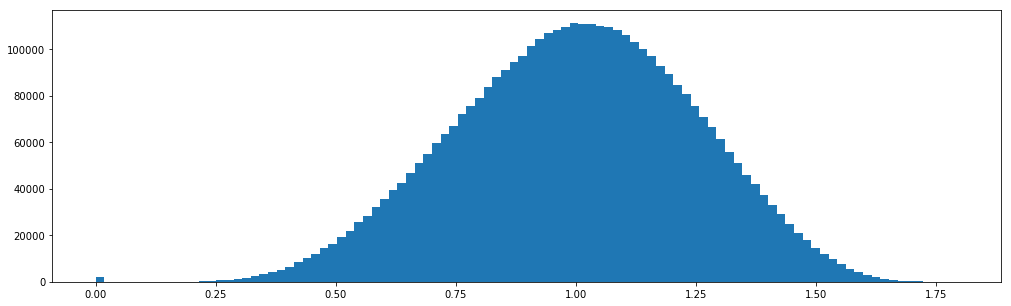

In [23]:
plt.hist(distances.flatten(), bins=100);

In [24]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

2002 distances equal exactly zero.


Why are some distances equal to zero? 

# Answered

** At least 2000 should be zero because it's the distance between a music (its features) and itself. One more pair is zero, it might be because of floating point precision (more likely) or could be because of a duplicate in our dataset. **
 

### 3.2 Weighted adjacency matrix

From our distances, we want to compute edge weights. If the distance is short, which means the tracks are similar, we want a strong edge. The most widespread kernel for that task is the Gaussian kernel, defined as
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right),$$
where $\sigma$ is a parameter which controls the width of the kernel.

Bonus. Can you think of another suitable kernel? 

# Answered

** We could simply change it to the similiraty measure being the opposite of distance (in a linear fashion. Hence, 1 means highly similar and 0 means NOT similar) : **

** We can also first scale it by the max, s.t. the most similar tracks have value 1 **

$$\mathbf{W}(u,v) = 1 - \frac{d(u, v)}{2 max(D)}$$

** Now if we want, we can divide this by two in order to have values between 0 and 1. **

Compute below the weight of each edge.

Hints:
* At first, you can set the kernel width, $\sigma$, to the mean value of the distance. (It will preserve the distribution of distances.)
* Don't forget to set the diagonal to zero! We don't want self-connections.

In [25]:
def dist_to_adj_matrix(dist, kernel_type):
    """
    Given a distance matrix, build an adjacency matrix using a given kernel_type
    
    Parameters
    ----------
    dist : ndarray
    distance matrix
    
    kernel_type : string
    kernel type ('gaussian' or 'linear')
    

    Returns
    -------
    out : ndarray
    Output array, adjacency matrix
    """
    
    if kernel_type == 'gaussian':
        kernel_width = dist.mean()
        mat = np.exp(-(dist / kernel_width)**2)
    
    elif kernel_type == 'linear':
        mat = 1 - dist/(dist.max() *2)
        
    else:
        raise ValueError('kernel_type unknown')
    
    np.fill_diagonal(mat, 0.0)
    return mat

In [111]:
all_weights = dist_to_adj_matrix(distances, 'gaussian')
all_weights.shape

(2000, 2000)

So we just created a fully connected graph. For our algorithms to be more efficient, we want to sparsify it. There are two main ways to sparsify a graph: i) thresholding all the weights smaller than an $\epsilon$, and ii) keep the $k$ strongest edges for each node. Implement below the second option. You can start with $k=100$.

Hints:
* You can use `np.argsort` to sort the weights.
* Be sure that your weight matrix stays symmetric.
* Look at both the sparsity pattern and the weight distribution as an indication of correctness.

In [112]:
def filter_neighbors(mat, neighbors):
    """
    Given a weights matrix, keep only the best edges/neighbors (edges with biggest weight)
    for each node
    
    Parameters
    ----------
    mat : ndarray
    weights matrix
    
    neighbors : int
    number of best edges/neighbors (at least) to keep for each node
    
    Returns
    -------
    out : ndarray
    Output array, the same weights matrix but with only the best edges/neighbors
    """
    filter_mat = np.empty_like(mat)
    
    # find best neighbors in the matrix
    best_ind = np.argsort(mat, axis=0)[::-1][:neighbors].T
    range_rows = np.arange(mat.shape[0])[:,np.newaxis]
    
    # add best neighbors (only) to the new matrix
    filter_mat[range_rows, best_ind] = mat[range_rows, best_ind]

    # make the matrix symmetric
    filter_mat += filter_mat.T * (filter_mat == 0)
    return filter_mat

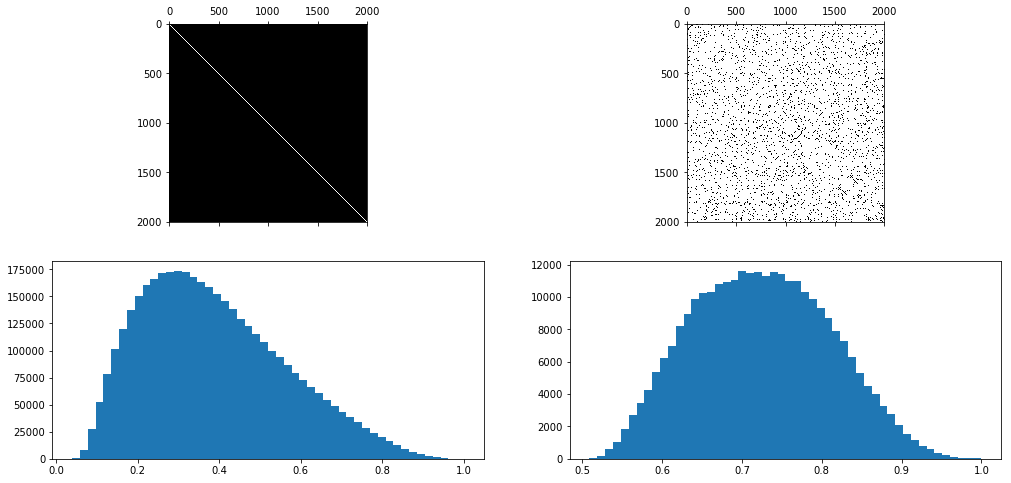

In [113]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

NEIGHBORS = 100
weights = filter_neighbors(all_weights, NEIGHBORS)

plot(all_weights, axes[:, 0])
plot(weights, axes[:, 1])

** Checking that the requested properties are actually true **

Symmetricity

In [114]:
assert np.count_nonzero(weights - weights.T) == 0

Min number of neighbors

In [115]:
assert np.min(np.count_nonzero(weights, axis=0)) == NEIGHBORS

### 3.3 Bonus: visualize the adjacency matrix

Can you think of a way to observe if the two genres form clusters in the graph we created? You should only use the weight matrix `weights` and the genre labels `tracks['genre']`.

# Answered

** The idea here is to order the weights per genre because music of the same genre should be more similar to each others. Hence, there should be more links between tracks of the same genres than between distinct genre **

In [116]:
ordering_rock_vs_pop = np.argsort(tracks['genre'].values)

weights_ordered = weights[ordering_rock_vs_pop][:, ordering_rock_vs_pop]

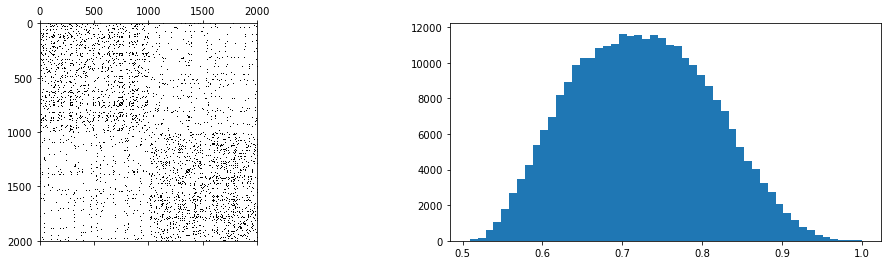

In [117]:
fix, axes = plt.subplots(1, 2, figsize=(17, 4))
plot(weights_ordered, axes)

** We see that tracks of the same genre (1000 tracks for each genre) are more linked to each others. This gives us a (big) hint that clusters exist in our graph. For this reason, we know that the Spectral graph theory should work in finding those cluster without knowing the labels. **

### 3.4 Degrees

Compute below the degree vector.

Hints:
* Again, looking at the degree distribution will help you identify any mistake.

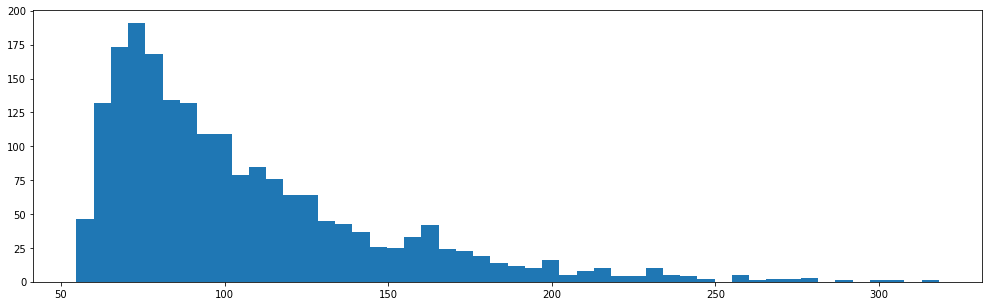

In [118]:
# Weighted degree distribution
degrees = np.sum(weights, axis=0)

plt.hist(degrees, bins=50);

### 3.5 Graph Laplacian

We will later need the Fiedler vector. Shall we compute the combinatorial or the normalized Laplacian? 

# AAA

**Your answer here.**

Implement your choice below. 

Hints:
* Compare the sparsity pattern of the Laplacian to the one of the weight matrix.

In [119]:
D = np.eye(weights.shape[0]) * degrees
W = weights
L = D - W

inv_root_D = np.eye(D.shape[0]) * (1 / np.diag(D**(0.5)))

normalized_laplacian = inv_root_D @ L @ inv_root_D

Looking at the pattern of the matrix we can be 

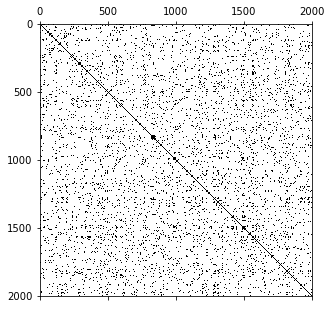

In [120]:
plt.spy(normalized_laplacian);

** We can verify our computations by using the scipy implementation of the normalized laplacian :**

In [121]:
scipy_laplacian = sparse.csgraph.laplacian(weights, normed=True)

precision = 1e-15
assert np.count_nonzero(normalized_laplacian - scipy_laplacian > precision) == 0

# note: the precision value used here can be different depending on your machine

For efficient storage and computation, we can store this sparse matrix in a [compressed sparse row (CSR)](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29) format.

In [122]:
laplacian = sparse.csr_matrix(scipy_laplacian)

# we used the scipy implementation as it should be more precise (better implementation),
# even though we obtain similar results with both.

Compute the number of remaining edges in the graph.

In [123]:
remaining_edges = np.count_nonzero(L) // 2

remaining_edges

# note: this includes self-edges

146226

## 4 Eigendecomposition of the graph Laplacian

The whole point of spectral graph theory is to compute the eigendecomposition of the Laplacian. We however don't need the full eigendecomposition (a.k.a. the graph Fourier basis) here. Compute the 10 eigenvectors with the smallest eigenvalues with one of the following functions: `np.linalg.eig`, `np.linalg.eigh`, `sparse.linalg.eigs`, `sparse.linalg.eigsh`. Justify your choice.

# AAA

**Your answer here.**

In [124]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SA')

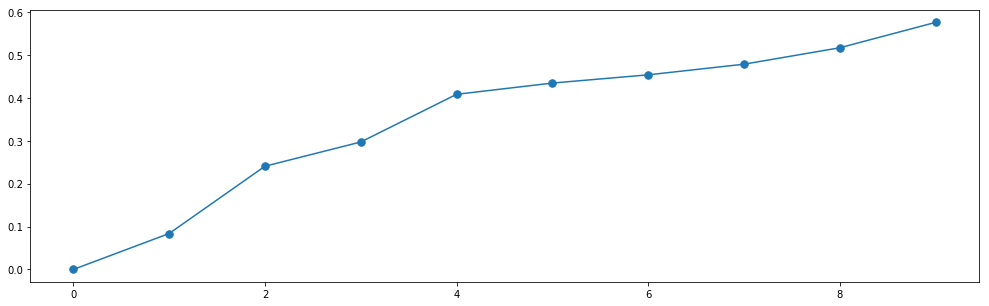

In [125]:
plt.plot(eigenvalues, '.-', markersize=15);

Why can we diagonalize the graph Laplacian in the first place? 

# AAA

**Your answer here.**

Why are all the eigenvalues real? 

# AAA

**Your answer here.**

Why are all the eigenvalues non-negative? 

# AAA

**Your answer here.**

### 4.1 Connectedness

Is the graph connected? Justify. Knowing how we built the graph, can we ensure it is connected?

# Answered

(From lecture slides 6, slide 10)

**The number of connected components $c$ of $G$ is the dimension of the nullspace of $L$.**

**Furthermore the null space of $L$ has a basis of indicator vectors of the connected components of $G$ **

In [126]:
dim_null_L = L.shape[0] - np.linalg.matrix_rank(L)

dim_null_L

1

** This means there is only one connected component, hence our graph is fully connected.**

**For completeness (for fun), let's verify it using our good old "networkx" library (we used this on previous labs)**

In [127]:
G = nx.from_numpy_matrix(L)
gc = max(nx.connected_component_subgraphs(G), key=len)

In [128]:
assert len(gc.nodes()) == weights.shape[0], "GCC should contain all nodes"

### 4.2 Eigenvector question

What do you expect as the result of the below computation? Justify. Do you get the value you expected? If not, why?

Note that `x @ y` (introduced in Python 3.5) is equivalent to `np.matmul(x, y)`. You should prefer the former as it makes it easier to read formulas.

In [130]:
np.sum(laplacian @ (2 * eigenvectors[:, 0]))

-2.3640757320503303e-15

# AAA

**Your answer here.**

### 5.1 Principal component analysis (PCA)

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a standard algorithm to reduce the dimensionality of a dataset. It computes the axes of principal variance and project the data on them. It does only use the features we computed, not the graph. We show it here for comparison. (We use [scikit-learn](http://scikit-learn.org), a very convenient library for Machine Learning.)

## 5 Visualization and clustering

Finally, let's use the data and graph we prepared. When [exploring data](https://en.wikipedia.org/wiki/Exploratory_data_analysis), it's often useful to visualize an entire dataset. Because for us humans it's hard to look at data in 140 dimensions, we need to somehow reduce the dimensionality to 2 or 3 and visualize the data in this more familiar space. While such a reduction will obviously be destructive, many algorithms have been developed to preserve certain properties.

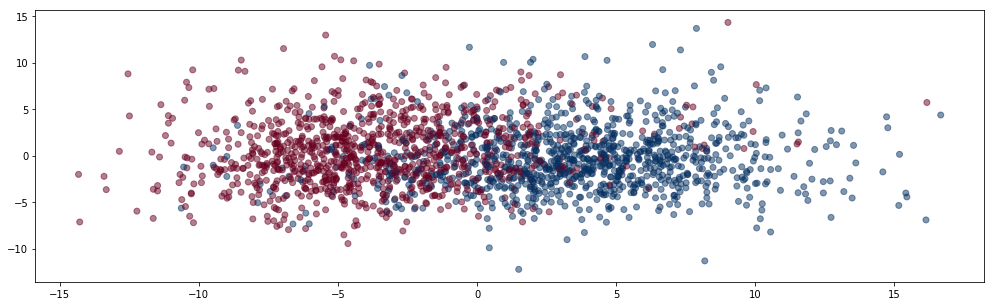

In [131]:
features_pca = decomposition.PCA(n_components=2).fit_transform(features)
genres = preprocessing.LabelEncoder().fit_transform(tracks['genre'])
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=genres, cmap='RdBu', alpha=0.5);

### 5.2 Graph embedding

Instead of using the features directly, we can try to visualize our similarity graph. That graph is embedded in an ambiant space of 140 dimensions (the number of features, that is the number of MFCCs times the number of summary statistics) at first, i.e. each node has a position in an 140-dimensional Euclidean space. Because we cannot visualize such an high-dimensional space, we want to embed the graph in a 2D space.

One way to embed a graph is to use the value of the eigenvectors as coordinates. For the below plot, use the value of the second eigenvector as the x coordinate of a node, and the value of the third eigenvector as the y coordinate. The color is indicated by the genre.

Why don't we use the first eigenvector? 


# AAA

**Your answer here.**

In [144]:
def plot_labels(eigenvectors, labels=None, ax=plt):
    """
    Scatter plot the labels onto value of the second eigenvector as the x coordinate of a node,
    and the value of the third eigenvector as the y coordinate
    
    Parameters
    ----------
    eigenvectors : ndarray
    eigenvectors used for the axis and (Fiedler vector) for the labels if none are given
    
    labels (optional) : ndarray
    labels to plot
    
    ax : matplotlib axis
    axis on which the plot is plotted
    
    Returns
    -------
    None
    """
    if labels is None:
        labels = eigenvectors[:, 1] < 0
    
    ax.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=labels, cmap='RdBu', alpha=0.5)

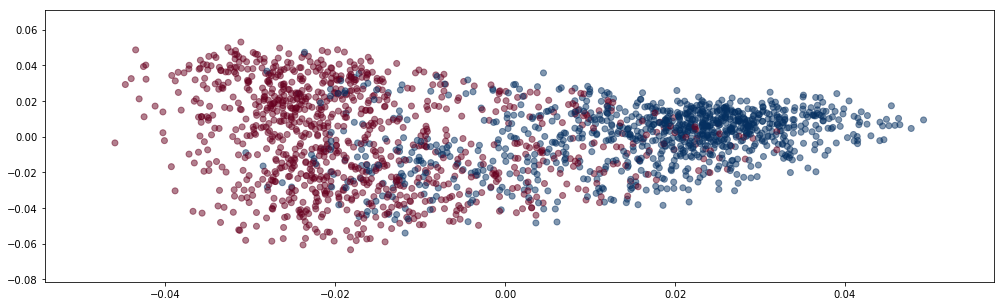

In [145]:
plot_labels(eigenvectors, labels=genres)

See how well this plot summarizes 2GB of data and 2000 tracks! We could now design a playlist generator as a random walk on this similarity graph and visualize its trajectory as it hops from track to track. :)

### 5.3 Clustering

Note how we did not try to build a machine to recognize the musical genre given a track (that would have been a [classification problem](https://en.wikipedia.org/wiki/Statistical_classification)). We did merely try to visualize the data, by means of PCA and a graph embedding algorithm. What does it tell us that genre clearly appears in our visualization?

# AAA
**Your answer here.**

As such, we can try to cluster the tracks with the Fiedler vector, and look if the (unsupervised) clustering agrees with the *ground truth* genre categorization. Reproduce below the above scatter plot, but with the sign of the Fiedler vector as the color instead of the genre.

In [146]:
# this function is asked in section 5.4

def compute_err(labels, genres=genres, print_=False):
    """
    Compute the error rate between labels (prediction) and genres (truth)
    
    Parameters
    ----------
    labels : ndarray
    predicted labels
    
    genres : ndarray
    genres (ground truth labels)
    
    print_ : boolean
    whether or not to print the number of errors and error rate
    
    Returns
    -------
    out : float
    Output error rate
    """
    err = np.abs(genres - labels).sum()
    perc_err = err/len(labels)
    
    # this is to cope with the fact that sometimes labels given by the eigenvectors
    # are the inverse of the real genres ('> 0' instead of '< 0')
    if perc_err > 0.5:
        err = len(labels) - err
        perc_err = 1 - perc_err
    if print_:
        print('{} errors ({:.2%})'.format(err, perc_err))
    return perc_err

In [147]:
def compare_plot_labels(eigenvectors, genres=genres):
    """
    Scatter plot the labels (both the ones given by the Fiedler vector and the ground truth (genres))
    onto value of the second eigenvector as the x coordinate of a node,
    and the value of the third eigenvector as the y coordinate
    
    Parameters
    ----------
    eigenvectors : ndarray
    eigenvectors used for the axis and for the labels if none are given
    
    genres : ndarray
    genres (ground truth labels)
    
    Returns
    -------
    None
    """
    f, axes = plt.subplots(nrows=1, ncols=2)
    spectral_labels = eigenvectors[:, 1] > 0
    for ax, labels, title in zip(axes.flatten(), [spectral_labels, genres], ["spectral clustering", "pop vs rock clutstering"]):
        ax.set_title(title)
        plot_labels(eigenvectors, labels, ax=ax)
    
    compute_err(spectral_labels, print_=True)

321 errors (16.05%)


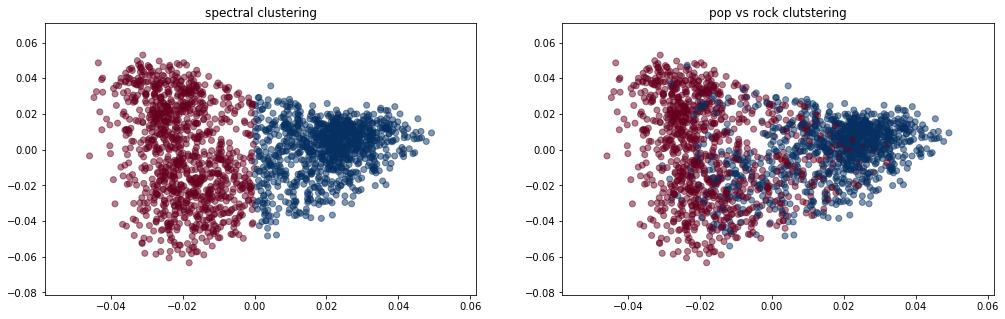

In [148]:
compare_plot_labels(eigenvectors)

### 5.4 Error rate

How many tracks were wrongly categorized by the Fiedler vector, according to the Rock / Hip-Hop ground truth?

In [137]:
labels = eigenvectors[:, 1] > 0
err = compute_err(labels, print_=True)

321 errors (16.05%)


Tune some parameters (e.g. `kernel_width`, `NEIGHBORS`), discard some features (section 2.4), change the distance metric (section 3.1) to get less errors. You should get an error rate below 15% (i.e. less than 300 errors in total). Try to understand the effect of each parameter. After data cleaning, parameter tuning is the other dirty work of a data scientist! Be aware that tuning the parameters on a specific dataset will lead to [overfitting](https://en.wikipedia.org/wiki/Overfitting).

In [138]:
def compute_eigenvectors(features, drop_stats=[], distance_metric='cosine', kernel_type='gaussian', neighbors=NEIGHBORS):
    """
    Compute the eigenvectors of the laplacian matrix built with some features
    statitics of a music track
    
    Parameters
    ----------
    features : ndarray
    features statistics matrix
    
    drop_stats : list(string)
    statistics to drop
    
    distance_metrix : string
    distance metric to use when computing the distance matrix
    
    kernel_type: string
    'gaussian' or 'linear' kernel to use when computing the weights matrix
    with the distance matrix
    
    neighbors : int
    number of best neighbors to keep from the weights matrix
    
    Returns
    -------
    out : ndarray
    Output array, the eigenvectors of the laplacian matrix computed with the features
    """
    features_ = features.copy()
    for s in drop_stats:
        features_.drop(('mfcc', s), axis=1, inplace=True)
    distances = features_to_dist_matrix(features_, distance_metric)
    all_weights = dist_to_adj_matrix(distances, kernel_type)
    weights = filter_neighbors(all_weights, neighbors)
    laplacian = sparse.csgraph.laplacian(weights, normed=True)
    _, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SA')
    return eigenvectors

### 5.5 (Over-)Fitting the labels

(overfitting because we tune our paramters just to get closer to the original labels, hence the probabilty to overfit is quite high)

### Using a parameter grids

As there are too many combinations of parameters possible, I decide to subdivide them into multiple grid searches. This may not result in finding the best parameters, but at least it won't run during hours.

In [139]:
def grid_search(param_grid):
    """
    Compute all error rates for the given combinations of parameters
    
    Parameters
    ----------
    param_grid : sklearn model_selection ParameterGrid
    grid of parameters (all combinations to try)
    
    Returns
    -------
    out : parameters, ndarray
    Output the best parameters and all the error rates
    """
    errors = np.array([compute_err(compute_eigenvectors(features, **p)[:, 1] > 0) for p in tqdm(param_grid)])
    return param_grid[np.argmin(errors)], errors

In [140]:
best_dist_metric_and_kernel, _ = grid_search(model_selection.ParameterGrid({
    'distance_metric': [
        'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'euclidean', 'hamming',
        'jaccard', 'matching', 'minkowski', 'seuclidean', 'sqeuclidean',
    ],
    'kernel_type': ['linear', 'gaussian'],}))

best_dist_metric_and_kernel

A Jupyter Widget

{'distance_metric': 'cityblock', 'kernel_type': 'gaussian'}

In [54]:
stats_name = ['mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max']
stats_combinations = [comb for n in range(1, len(stats_name)) for comb in it.combinations(stats_name, n)]
best_drop_stats, _ = grid_search(model_selection.ParameterGrid({
    'distance_metric': [best_dist_metric_and_kernel['distance_metric']],
    'kernel_type': [best_dist_metric_and_kernel['kernel_type']],
    'drop_stats': stats_combinations,
}))

best_drop_stats['drop_stats']

A Jupyter Widget

('kurtosis', 'min', 'max')

In [55]:
param_grid = model_selection.ParameterGrid({
    'distance_metric': [best_dist_metric_and_kernel['distance_metric']],
    'kernel_type': [best_dist_metric_and_kernel['kernel_type']],
    'drop_stats': [best_drop_stats['drop_stats']],
    'neighbors': np.linspace(2, 500, 50, dtype=int),
})

In [56]:
best_params, errors = grid_search(param_grid)
best_params, errors.min()

A Jupyter Widget

({'distance_metric': 'euclidean',
  'drop_stats': ('kurtosis', 'min', 'max'),
  'kernel_type': 'gaussian',
  'neighbors': 32},
 0.13350000000000001)

### Nice results but let's try another grid search as well

We can see that we end up with different distance metric, kernel_type and also 3 features statistics less. What is also surprising is the very small number of neighbors kept.

For completness (or fun) we can try a final grid search with the orginal distance metric and kernel_type :

In [57]:
best_drop_stats_orig, _ = grid_search(model_selection.ParameterGrid({
    'drop_stats': stats_combinations,
}))

best_drop_stats_orig['drop_stats']

A Jupyter Widget

('min', 'max')

In [58]:
param_grid_orig = model_selection.ParameterGrid({
    'drop_stats': [best_drop_stats_orig['drop_stats']],
    'neighbors': np.linspace(2, 500, 50, dtype=int),
})

In [59]:
best_params_orig, errors_orig = grid_search(param_grid_orig)
best_params_orig, errors_orig.min()

A Jupyter Widget

({'drop_stats': ('min', 'max'), 'neighbors': 12}, 0.13)

As we can see, the subdivided grid searchs didn't find this combination which is better

### Final score (best overall)

260 errors (13.00%)


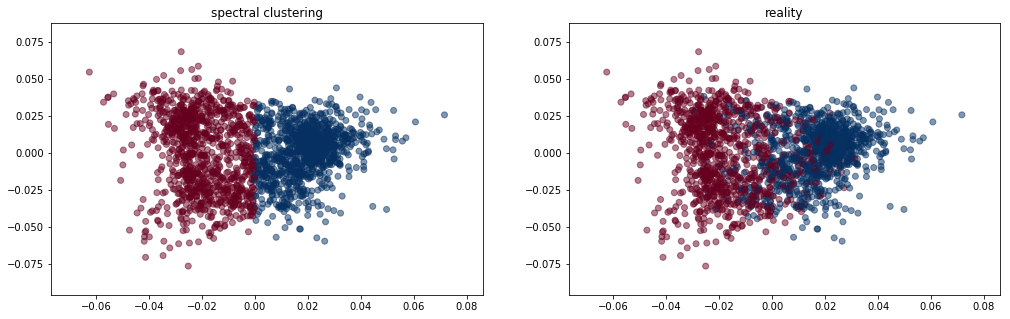

In [108]:
best_eigenvectors = compute_eigenvectors(features, **best_params_orig)

compare_plot_labels(best_eigenvectors)

## 6 Conclusion

Among other things, this assignment showed us that a graph can be useful for e.g. visualization or clustering, even when there is none in the original data. One of the design goal of this assignment, while dealing with real data, was to follow the complete Data Science process, from data acquisition to interpretation of the results. The exploitation of the data showed us that a machine can discern musical genres by looking at pairwise distances between spectral features extracted from audio recordings.

### 6.1 Bonus

What is the name of the technique we used to visualize the data in the last two plots? What does it try to preserve when reducing the dimensionality (of the ambiant space) from 140 to 2?

# AAA
**Your answer here.**

**General Comments:**

Please note that some results (plots) might <i>slightly</i> differ when the notebook is runned again or on a different machine.
This doens't change the anything about what we have concluded.

(I guess it's due to floating points errors)